# Case Study 6.1 - NYC Taxi Trips

<h1 style="color:red;">Note: If you close this notebook at any time, you will have to run all cells again upon re-opening it.</h1>

<h1 style="color:red;">Note: You may get different numerical results running the notebook different times. This is to be expected, you can just report whatever results you get.</h1>

# ADVANCED PYTHON

As this is an advanced version, we don't include a lot of code here. If you get stuck on a particular part, feel free to also use the beginner version in `beginnner_python.ipynb` to help you out.

If you don't know your MITx username, you can create a test post [here](https://courses.xpro.mit.edu/courses/course-v1:xPRO+DSx+R11/discussion/forum/general/threads/5db91a5c59a54c4eb6000031) to find it.

# Identification Information

In [ ]:
# YOUR NAME              = Xiaoyang Gong
# YOUR MITX PRO USERNAME = xiaoyang-gong
# YOUR MITX PRO E-MAIL   = shawn.xygong@gmail.com

# Setup

Run these cells to install all the packages you need to complete the remainder of the case study. This may take a few minutes, so please be patient.

<h1 style="color:red;">Note: You may see red errors when you run the cell below. As long as you can run the Import cell below and see "Import successful!", you can continue with the case study.</h1>

In [1]:
!pip install --upgrade pip
!pip install featuretools==0.1.19
!pip install pandas==0.20.3

     |████████████████████████████████| 1.5MB 1.1MB/s eta 0:00:01
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 133 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 6.3 MB 33 kB/s  eta 0:00:01     |████████▋                       | 1.7 MB 2.2 MB/s eta 0:00:03
     |████████████████████████████████| 75 kB 144 kB/s eta 0:00:01
  Created wheel for featuretools: filename=featuretools-0.1.19-py3-none-any.whl size=160178 sha256=b18f8d94726feb68f9f6bcdcc307a3b3f0ac8f325725455bf0721f35eb18162e
  Stored in directory: /home/nbuser/.cache/pip/wheels/4f/f1/aa/7bca5250bcc0365ac8d5a71ffe6d978da04ffeaa45d71943c8
Successfully built featuretools
ERROR: boto3 1.4.8 has requirement botocore<1.9.0,>=1.8.0, but you'll have botocore 1.17.7 which is incompatible.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.8.50
    Uninstalling botocore-1.8.50:
      Succe

# Import

In [13]:
import featuretools as ft
import matplotlib
import numpy as np
import pandas as pd
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min, Minute, Month, Std, Sum, Week, Weekday, IsWeekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)

In [14]:
%matplotlib inline

# Data

- Use `load_nyc_taxi_data` to get the data.
- Use `preview` to preview the data.
- Create a histogram of the `trip_duration` column of the `trips` table.

In [25]:
# Your code here to load, preview and visualize data
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()

In [16]:
# Preview the data
preview(trips)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I


In [17]:
preview(pickup_neigh)

,neighborhood_id,latitude,longitude
0,AH,40.804349,-73.961716
1,Z,40.715828,-73.954298
2,D,40.750179,-73.992557
3,AT,40.729670,-73.981693
4,AG,40.749843,-74.003458


In [18]:
preview(dropoff_neigh)

,neighborhood_id,latitude,longitude
0,C,40.783780,-73.953145
1,S,40.836792,-73.934381
2,AL,40.818445,-73.948046
3,J,40.799573,-73.940427
4,AV,40.776270,-73.982322


The number of trips in the dataset is: 10000


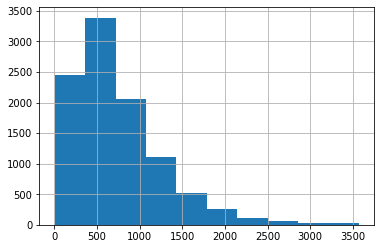

In [19]:
# Histogram on the trip_duration on the trips table
trips.trip_duration.hist()

# Number of trips in the dataset
print("The number of trips in the dataset is:", trips.shape[0])

<h1 style="color:red;">QUESTION 1: DATA ANALYSIS</h1>

**Describe the dataset. How many trips are in the dataset? How would you describe the distribution of trip durations? Is there anything else we should observe? Make sure the histogram is visible in the notebook.**

There are 10000 trips in the dataset. The distribution looks like a log normal distribution.

# Entities and Relationships

Construct a dictionary of entities and relationships. You can read about the format of these objects [`here`](https://docs.featuretools.com/en/stable/generated/featuretools.dfs.html).

In [26]:
# Construct entities and relationships dicts
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

# Transform Primitives

In [23]:
# Make list of transform primtivies that only contains the Weekend object from above
transform_primitive = [IsWeekend]

In [36]:
# Then, use featuretools.dfs to get the features
# See https://docs.featuretools.com/generated/featuretools.dfs.html
# target entity should match name for trips entity in your entities dictionary
# no agg_primitives yet
# ignore the lat/long for dropoff and pickup
feature_weekend, feature_weekend_defs = ft.dfs(entities = entities,
                           relationships = relationships,
                           target_entity = "trips",
                           agg_primitives = [],
                           trans_primitives = transform_primitive,
                           ignore_variables = {"trips" : ["pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude", "trip_duration"]})

In [40]:
# Print out the features you just made
feature_weekend_encode, feature_encode = ft.encode_features(feature_weekend, feature_weekend_defs)

In [41]:
# Use compute_features to get the feature matrix from the list of features you just made

preview(feature_weekend_encode)


,vendor_id,passenger_count,trip_distance,payment_type = 1,payment_type = 2,payment_type = 3,payment_type = 4,payment_type is unknown,pickup_neighborhood = AA,pickup_neighborhood = D,...,dropoff_neighborhood = AB,dropoff_neighborhood = AV,dropoff_neighborhood = AP,dropoff_neighborhood is unknown,IS_WEEKEND(dropoff_datetime),IS_WEEKEND(pickup_datetime),pickup_neighborhoods.latitude,pickup_neighborhoods.longitude,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude
id,,,,,,,,,,,,,,,,,,,,,
514030,2,1,2.46,1,0,0,0,0,1,0,...,0,0,0,1,True,True,40.757707,-73.986446,40.766809,-73.956886
514031,1,2,7.90,1,0,0,0,0,0,0,...,0,0,0,1,True,True,40.744928,-73.919159,40.793597,-73.969822
514032,1,1,1.00,1,0,0,0,0,0,0,...,0,0,0,1,True,True,40.729652,-73.991595,40.740333,-74.005107
514033,2,1,0.02,0,1,0,0,0,0,0,...,0,0,0,1,True,True,40.720245,-73.987205,40.720245,-73.987205
514034,1,2,19.00,1,0,0,0,0,0,0,...,0,0,0,1,True,True,40.646194,-73.785073,40.785005,-73.976050


# First Model

In [56]:
# Split feature matrix (75% train, 25% test) using utils.train_test_fm
# Pass in features, trips dataframe, and fraction train (0.75)
x_train, y_train, x_test, y_test = utils.get_train_test_fm(feature_weekend_encode, trips, 0.75)

In [57]:
# Use np.log(x + 1) to take the log of a particular vector x - this helps create a more linear relationship
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [58]:
# Then, create a GradientBoostingRegressor
# Fit to training
# Score on testing
model = GradientBoostingRegressor(verbose = True)
model.fit(x_train, y_train)


      Iter       Train Loss   Remaining Time 
         1           0.4736            3.36s
         2           0.4148            2.12s
         3           0.3661            1.65s
         4           0.3266            1.39s
         5           0.2934            1.25s
         6           0.2665            1.16s
         7           0.2441            1.07s
         8           0.2257            1.02s
         9           0.2103            0.97s
        10           0.1973            0.92s
        20           0.1434            0.70s
        30           0.1312            0.58s
        40           0.1257            0.48s
        50           0.1225            0.39s
        60           0.1202            0.31s
        70           0.1184            0.23s
        80           0.1168            0.15s
        90           0.1156            0.08s
       100           0.1138            0.00s


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=True,
                          warm_start=False)

In [59]:
print(model.score(x_test,y_test))

0.7533221310797884


<h1 style="color:red;">QUESTION 2: FIRST MODEL</h1>

**Describe all the features that we added to the model. Do you think these improved the performance from a model that did not have these features? Why?**

*Type your response here...*

# More Transform Primitives

In [61]:
# Make list of transform primtivies that contain new primitives described in the instruction manual
transform_list = [Minute, Hour, Week, Month, Weekday]

In [66]:
# Compute features
feature_matrix, features = ft.dfs(entities = entities,
                           relationships = relationships,
                           target_entity = "trips",
                           agg_primitives = [],
                           trans_primitives = transform_list,
                           ignore_variables = {"trips" : ["pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude", "trip_duration"]})

In [73]:
# Compute feature matrix
feature_matrix_encode, encoded_features = ft.encode_features(feature_matrix, features)

In [74]:
# Re-split feature matrix
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix_encode, trips, 0.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)


In [75]:
# Train and score NEW model
model = GradientBoostingRegressor(verbose = True)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.48s
         2           0.4148            1.47s
         3           0.3661            1.39s
         4           0.3266            1.32s
         5           0.2934            1.27s
         6           0.2665            1.23s
         7           0.2441            1.22s
         8           0.2257            1.19s
         9           0.2103            1.18s
        10           0.1973            1.16s
        20           0.1434            1.01s
        30           0.1306            0.89s
        40           0.1241            0.75s
        50           0.1194            0.64s
        60           0.1161            0.51s
        70           0.1140            0.38s
        80           0.1116            0.25s
        90           0.1084            0.13s
       100           0.1045            0.00s
0.7519675814605612


<h1 style="color:red;">QUESTION 3: SECOND MODEL</h1>

**Describe the rest of the new features that we just added to the model. How did this affect performance? Did we have to sacrifice training time?**

*Type your response here...*

# Aggregation Primitives

In [76]:
# Make list of transform primtivies that are the same as above
# Make a list of aggregation primitives containing Count, Sum, Mean, Median, Std, Max, Min
transform_list = [Minute, Hour, Week, Month, Weekday, IsWeekend]
aggregation_list = [Count, Sum, Mean, Median, Std, Max, Min]


In [77]:
# Compute features

feature_matrix, features = ft.dfs(entities = entities,
                           relationships = relationships,
                           target_entity = "trips",
                           agg_primitives = aggregation_list,
                           trans_primitives = transform_list,
                           ignore_variables = {"trips" : ["pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude", "trip_duration"]})

In [78]:
# Compute feature matrix
feature_matrix_encoded, features_encoded = ft.encode_features(feature_matrix, features)


In [84]:
# Re-split feature matrix
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix_encoded, trips, 0.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [85]:
# Train and score NEW model
model = GradientBoostingRegressor(verbose = True)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))

      Iter       Train Loss   Remaining Time 
         1           0.4736            3.06s
         2           0.4148            2.83s
         3           0.3661            2.74s
         4           0.3266            2.66s
         5           0.2934            2.61s
         6           0.2665            2.55s
         7           0.2441            2.52s
         8           0.2257            2.50s
         9           0.2103            2.46s
        10           0.1973            2.43s
        20           0.1427            2.19s
        30           0.1292            1.88s
        40           0.1225            1.60s
        50           0.1181            1.32s
        60           0.1151            1.08s
        70           0.1124            0.81s
        80           0.1103            0.54s
        90           0.1079            0.27s
       100           0.1027            0.00s
0.7535658437548765


# Evaluate on Test Data

In [ ]:
# Use .predict() function on your latest model to get y_pred from X_test

In [ ]:
# Print some of the predictions

In [ ]:
# Create histogram of predictions

<h1 style="color:red;">QUESTION 4: MODEL PREDICTIONS</h1>

**Analyze the model predictions. Does the output distribution match the one you made earlier in the case study? What other features/strategies could we use to make our model even better, if we had more time?**

*Type your response here...*

# Feature Importance

In [86]:
# Compute feature importance of model
# You can use the feature_importances function we defined for you
# Or, see the feature_importances_ attribute of our model
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
feature_importances(model, feature_matrix_encoded.columns, n=25)

1: Feature: trip_distance, 0.886
2: Feature: dropoff_neighborhoods.longitude, 0.027
3: Feature: dropoff_neighborhoods.latitude, 0.021
4: Feature: MINUTE(pickup_datetime), 0.006
5: Feature: MINUTE(dropoff_datetime), 0.005
6: Feature: pickup_neighborhoods.longitude, 0.004
7: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.004
8: Feature: HOUR(pickup_datetime) = 2, 0.004
9: Feature: HOUR(pickup_datetime) = 1, 0.003
10: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.003
11: Feature: dropoff_neighborhoods.SUM(trips.passenger_count), 0.003
12: Feature: HOUR(pickup_datetime) is unknown, 0.003
13: Feature: pickup_neighborhoods.latitude, 0.002
14: Feature: pickup_neighborhoods.COUNT(trips), 0.002
15: Feature: pickup_neighborhoods.MEAN(trips.trip_distance), 0.002
16: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
17: Feature: dropoff_neighborhoods.SUM(trips.vendor_id), 0.002
18: Feature: dropoff_neighborhood = AA, 0.001
19: Feature: dropoff_neighborhoods.C

<h1 style="color:red;">QUESTION 5: FEATURE IMPORTANCE</h1>

**Analyze the feature importance values you just computed above. Do they make sense? Are there any values you are surprised by? Give some brief explanations as to why these features are relevant in computing the `trip_duration` target variable.**

*Type your response here...*

<hr>

Great job! Now, make sure you check out the **Conclusion** section of the [instruction manual](https://courses.edx.org/asset-v1:MITxPRO+DSx+2T2018+type@asset+block@6.1_instruction_manual.html) to wrap up this case study properly.